## Sección 0. Preparación del entorno.

#### Importar de librerías

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf
import _pickle as pickle
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

#### Montar unidad de disco de Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#### Definición de parámetros y rutas

In [ ]:
# Load min&max data of age for MinMaxScaler
pickle_file = '/content/drive/MyDrive/TFM/age_scaler.pickle'
with open(pickle_file, 'rb') as f:
  age_scaler = pickle.load(f)
max_age, min_age = age_scaler['max_age'], age_scaler['min_age']

In [ ]:
# IMAGES
IMG_WIDTH_OG = IMG_HEIGHT_OG = 200
IMG_SIZE_OG = [IMG_HEIGHT_OG, IMG_WIDTH_OG]
IMG_SHAPE_OG = [*IMG_SIZE_OG, 3]
IMG_WIDTH_ENB0 = IMG_HEIGHT_ENB0 = 224
IMG_SIZE_ENB0 = [IMG_HEIGHT_ENB0, IMG_WIDTH_ENB0]
IMG_SHAPE_ENB0 = [*IMG_SIZE_ENB0, 3]

# HIPERPARAMETERS
BATCH_SIZE = 256
DELTA = 5e-4

# FILE PATHS AND FILE NAMES
GCS_BUCKET = 'info-bucket-gcs-tfm'
FIGS_PATH = '/content/drive/MyDrive/TFM/figs'
MODELS_PATH = '/content/drive/MyDrive/TFM/models/'
TRAIN_FILE = 'train.pickle'
GENDER_TEST_FILE = 'test_gender.pickle'
AGE_TEST_FILE = 'test_age.pickle'
MODEL_FILE = 'model.h5'

# DATA DEFINITIONS
alias = {0: 'male', 1: 'female'}
tasks = ['gender', 'age', 'mtl']
task_error = 'task must be in [\'gender\', \'age\', \'mtl\']'

## Sección 1. Implementación de funciones

### Sección 1.1. Normalizaciones

In [ ]:
def no_norm(data):
  """No scale is applied to data"""
  return data

def no_denorm(data):
  """No scale is applied to data"""
  return data

def norm_01(data):
  """Data is normalized between 0 and 1"""
  return (data - min_age) / (max_age - min_age)

def denorm_01(data):
  """Data is denormalized from 0 and 1 to their actual range"""
  return data * (max_age - min_age) + min_age

def norm_11(data):
  """Data is normalized between -1 and 1"""
  return 2 * norm_01(data) - 1

def denorm_11(data):
  """Data is denormalized from -1 and 1 to their actual range"""
  return denorm_01((data + 1)/2)

# Dictionary of functions
dict_norm = {
    'no_norm': no_norm,
    'norm_01': norm_01,
    'norm_11': norm_11
}
dict_denorm = {
    'no_norm': no_denorm,
    'norm_01': denorm_01,
    'norm_11': denorm_11
}

### Sección 1.2. Gráficas de entrenamiento

In [ ]:
def get_best_epoch(H, task, delta):
  """
    Calculates best epoch of model based of task and given metric from history.

    Parameters:
      H (list): values of metric used for determinating best epoch
      task (str): 'gender', 'age' or 'mtl' determinates task of interest
      delta (float): minimum improvement to be taken into account
    
    Returns:
      int: best epoch of model
  """
  epoch, b_val = 0, 0 if task == 'gender' else 99999
  for i, val in enumerate(H):
    if task == 'gender':
      if val > b_val + delta:
        epoch, b_val = i + 1, val
    else:
      if val < b_val - delta:
        epoch, b_val = i + 1, val
  return epoch

In [ ]:
def plot_training(pickle_file, save=False):
  """
    Plots model performance over train and validation sets from pickle file.
    Best epoch is highlinend in red. Figure can be save.
  
    Parameters:
      pickle_file (str): complete path name of file with data to be plotted
      save (bool): if True, result plot will be saved at FIGS_PATH
  """
  def clean_key(text):
    """Remove word from keys for extracting metric names"""
    for word in ['gender', 'age', 'output', '_']:
      text = text.replace(word, ' ').strip()
    return text
  
  def print_results(H, task, keys):
    """Prints model performance over validation set and return best epoch"""
    if task == 'mtl':
      b_epoch = get_best_epoch(H['val_loss'], task, DELTA)
      val_acc = H[keys[-3]][b_epoch - 1]
      val_mae = H['val_age_output_mean_absolute_error'][b_epoch-1]
      print(f'Best epoch: {b_epoch}, Gender accuracy: {val_acc:.2%},',
            f'Age MAE: {val_mae:.6f}')
    elif task == 'gender':
      b_epoch = get_best_epoch(H[keys[-1]], task, DELTA)
      val_acc = H[keys[-1]][b_epoch - 1]
      print(f'Best epoch: {b_epoch}, Gender accuracy: {val_acc:.2%}')
    else:
      b_epoch = get_best_epoch(H['val_loss'], task, DELTA)
      val_mae = H['val_mean_absolute_error'][b_epoch-1]
      print(f'Best epoch: {b_epoch}, Age MAE: {val_mae:.6f}')
    return b_epoch
  
  with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
  og_task = pickle_file.split('/')[8]
  h, keys = data['history'], list(data['history'].keys())
  epochs = list(range(1, len(h['loss']) + 1)) # Axis of epochs
  b_epoch = print_results(h, og_task, keys)

  if og_task == 'mtl': # set params for plotting according to task
    y, offset, my_range = 2, 6, [1 , 4 ,3, 5]
    task = ['Gender', 'Age']
  elif og_task == 'gender':
    y, offset, my_range = 1, 2, [0, 1]
    task = ['Gender'] * 2
  else:
    y, offset, my_range = 1, 3, [1, 2]
    task = ['Age'] * 2

  fig, ax = plt.subplots(figsize=(7*y, 4*(1+y/2))) # Adapt size to num plots

  for i, j in enumerate(my_range):
    ax = plt.subplot(2, y, i + 1)
    ax.plot(epochs, h[keys[j]])
    ax.plot(epochs, h[keys[j+offset]])
    ax.axvline(x=b_epoch, color='r') # best epoch during training
    ax.set_title('{} - {}'.format(task[i%2], clean_key(keys[j])))
    ax.set_ylabel(clean_key(keys[j]).capitalize())
    ax.set_xlabel('Epochs')
    ax.legend(['Train', 'Validation'], loc='best')
  
  plt.tight_layout()

  if save:
    fig_path = os.path.join(FIGS_PATH, f'RESULTS_{og_task}_training.png')
    plt.savefig(fig_path, dpi=200)
    print(f'Figure save in {fig_path}')

### Sección 1.3. Comparativa rendimiento de modelos

In [ ]:
def compare_models(dir_path, task, filter_dict=None, hide_cols=[], 
                   sort_by=None, ascending=True, to_save=False):
  """
    Gets a pd.DataFrame with all models that matchs conditions in 'dir_path'.
    A filter can be set for CONFIG dir and column can be hide with 'hide_cols'
    list. Also it is possible to sort data with 'sort_by' and 'ascending'.

    Parameters:
      dir_path (str): complete path where train and test files are stored
      task (str): 'gender', 'age' or 'mtl' determinates task of interest
      filter_dict (dict): allows to filter data in CONFIG dir
      hide_cols (list): hides columns which are specified
      sort_by (str): sort rows by existing column in pd.DataFrame
      ascending (bool): sort ascending vs. descending
      to_save (bool): if True set float format to 4 decimals

    Returns:
      pd.DataFrame: df with info about dataset
  """
  assert task in tasks, task_error # Check if task is OK
  dd = {'hw': [], 'net': [], 'fold': [], 'phase': [], 'activ_gender': [],
        'activ_age': [], 'norm': [], 'age_loss': [], 'gamma': [],'lr': [],
        'time': [], 'b_epoch': [], 'train_acc': [], 'train_mse': [],
        'train_mae': [], 'val_acc': [], 'val_mse': [], 'val_mae': [],
        'test_acc': [], 'test_mse': [], 'test_mae': []}

  cols = list(dd.keys()) # All columns in dictionary
  train_files = glob(os.path.join(dir_path, TRAIN_FILE))
  gtest_files = atest_files = [None]*len(train_files)
  if task in ['gender', 'mtl']:
    gtest_files = glob(os.path.join(dir_path, GENDER_TEST_FILE))
    remove_cols = ['activ_age', 'norm', 'age_loss', 'gamma', 'train_mse',
                   'train_mae', 'val_mse', 'val_mae', 'test_mse', 'test_mae']
  if task in ['age', 'mtl']:
    atest_files = glob(os.path.join(dir_path, AGE_TEST_FILE))
    remove_cols = ['activ_gender', 'gamma', 'train_acc', 'val_acc', 'test_acc']
  if task == 'mtl': # In MTL all columns have valuable information
    remove_cols = []

  for train_f, gtest_f, atest_f in zip(train_files, gtest_files, atest_files):
    with open(train_f, 'rb') as pickle_file:
      train = pickle.load(pickle_file)
    info = train_f.split('/')
    dd['hw'].append(info[6])
    dd['net'].append(info[7])
    dd['fold'].append(info[9])
    dd['phase'].append(info[10])
    config = info[11].split('-')
    dd['lr'].append(float(train['learning_rate']))
    dd['time'].append(train['training_time'])
    H, keys = train['history'], list(train['history'].keys())
    monitor = keys[-1] if task == 'gender' else 'val_loss'
    b_epoch = get_best_epoch(H[monitor], task, DELTA)
    dd['b_epoch'].append(b_epoch)
    if task in ['gender', 'mtl']:
      dd['activ_gender'].append(config[0])
      dd['train_acc'].append(
          f'{H[keys[1 if task == "gender" else 3]][b_epoch-1]:.2%}')
      dd['val_acc'].append(
          f'{H[keys[-1 if task == "gender" else -3]][b_epoch-1]:.2%}')
      with open(gtest_f, 'rb') as pickle_file:
        gtest = pickle.load(pickle_file)
      y_real, y_pred = gtest['real'], gtest['pred']
      dd['test_acc'].append(f'{ACC(y_real, y_pred):.2%}')
    if task in ['age', 'mtl']:
      dd['activ_age'].append(config[0 if task == 'age' else 1])
      norm = dict_norm[config[1 if task == 'age' else 2]]
      dd['norm'].append(norm.__name__)
      dd['age_loss'].append(config[2 if task == 'age' else 3])
      mae_norm, mse_norm = 1, 1
      if norm.__name__ == 'no_norm':
        mae_norm = max_age - min_age
        mse_norm = mae_norm**2
      dd['train_mse'].append(
          H[keys[1 if task == "age" else 4]][b_epoch-1]/mse_norm)
      dd['train_mae'].append(
          H[keys[2 if task == "age" else 5]][b_epoch-1]/mae_norm)
      dd['val_mse'].append(H[keys[-2]][b_epoch-1]/mse_norm)
      dd['val_mae'].append(H[keys[-1]][b_epoch-1]/mae_norm)
      with open(atest_f, 'rb') as pickle_file:
        atest = pickle.load(pickle_file)
      y_real, y_pred = atest['real'], atest['pred']
      dd['test_mse'].append(MSE(norm(y_real), norm(y_pred))/mse_norm)
      dd['test_mae'].append(MAE(norm(y_real), norm(y_pred))/mae_norm)
    if task == 'mtl':
      dd['gamma'].append(float(config[-1].replace('gamma_', '')))

  df = pd.DataFrame.from_dict({ # skip removed or hided columns
      k: v for k, v in dd.items() if k not in [*remove_cols, *hide_cols]})

  if filter_dict: # Show only indexes that match filter condition
    df = df.loc[reduce(
        lambda a, b: a & b, [df[k] == v for k, v in filter_dict.items()])]
  if sort_by: # Sort values by 'sort_by'
    df = df.sort_values(sort_by, ascending=ascending).reset_index(drop=True)

  if to_save: # Set float format
    pd.options.display.float_format = '{:,.4f}'.format
  else:
    pd.options.display.float_format = None
    
  return df

### Sección 1.4. Gráficas Multi-task learning

In [ ]:
def plot_gamma(df, dataset='test', save_name=None):
  """
    Plots gender accuracy and age MAE over gamma values. Train, validation and
    test datasets can be used with 'dataset' arg. Plot can be save.

    Parameters:
      df (pd.DataFrame): information of models is in this pd.DataFrame
      dataset (str): 'train', 'valid' or 'test' can be used as dataset
      save_name (str): name of file where plot will be saved
  """
  def str2num(df):
    """Converts str to num removing % simbol"""
    return df.replace('\%','', regex=True).astype(float)

  dff = df.sort_values('gamma')
  fig, ax = plt.subplots()

  # Accuracy for gender
  ax.plot(dff.gamma, str2num(dff[f'{dataset}_acc']), color='red', marker='o')
  ax.set_xlabel('Gamma', fontsize=14)
  ax.set_ylabel('Gender accurary (%)', color='red', fontsize=14)
  ax.set_title('Optimize gamma value', fontsize=16)
  # MAE for age
  ax2=ax.twinx()
  ax2.plot(dff.gamma, str2num(dff[f'{dataset}_mae']), color='blue', marker='o')
  ax2.set_ylabel('Age MAE (years)', color='blue', fontsize=14)

  plt.tight_layout()

  if save_name:
    fig_path = os.path.join(FIGS_PATH, f'RESULTS_{save_name}.png')
    plt.savefig(fig_path, dpi=200)
    print(f'Figure save in {fig_path}')

In [ ]:
def plot_cv(df, dataset='test', save_name=None):
  """
    Plots gender accuracy and age MAE over folds. Train, validation and
    test datasets can be used with 'dataset' arg. Plot can be save.

    Parameters:
      df (pd.DataFrame): information of models is in this pd.DataFrame
      dataset (str): 'train', 'valid' or 'test' can be used as dataset
      save_name (str): name of file where plot will be saved
  """
  def str2num(df):
    """Converts str to num removing % simbol"""
    return df.replace('\%','', regex=True).astype(float)

  dff = df.copy()
  dff['num_fold'] = dff.fold.map(lambda x: int(x.replace('fold', '')))
  dff = dff.sort_values('num_fold')
  
  fig, ax = plt.subplots(figsize=(12, 5))

  # Accuracy for gender
  ax.plot(dff.fold, str2num(dff[f'{dataset}_acc']), color='red', marker='o')
  ax.set_xlabel('Fold', fontsize=14)
  ax.set_ylabel('Gender accurary (%)', color='red', fontsize=14)
  ax.set_title('11-fold cross valitadion', fontsize=16)
  # MAE for age
  ax2=ax.twinx()
  ax2.plot(dff.fold, str2num(dff[f'{dataset}_mae']), color='blue', marker='o')
  ax2.set_ylabel('Age MAE (years)', color='blue', fontsize=14)
  
  plt.tight_layout()

  if save_name:
    fig_path = os.path.join(FIGS_PATH, f'RESULTS_{save_name}.png')
    plt.savefig(fig_path, dpi=200)
    print(f'Figure save in {fig_path}')

### Sección 1.5. Gráficas de test

In [ ]:
def test_model(path, task, save=False, msg=True):
  """
    Plots confusion matrix and/or scatter plot according to 'task' argument from
    'path' where pickle files are stored. Figures can be save.

    Parameters:
      path (str): file path where gender and age pickle files are stored
      task (str): 'gender', 'age' or 'mtl' determinates task of interest
      save (bool): if True figures will be save in fixed directory
      msg (bool): information will be displayed while function runs
  """
  def test_gender(pickle_file, save_name, msg):
    """Loads data and plots confusion matrix. Figure can be save"""
    with open(pickle_file, 'rb') as f:
      data = pickle.load(f)
    y_real, y_pred = data['real'], data['pred']
    labels = ['female', 'male']

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(4, 3))
    cmatrix = confusion_matrix(y_real, y_pred)

    sns.heatmap(cmatrix, cmap='Blues', annot=True, fmt='d', cbar=False)
    ax.set_title(f'Confusion matrix')
    ax.set_xlabel('Prediction')
    ax.set_xticklabels(labels)
    ax.set_ylabel('Real value')
    ax.set_yticklabels(labels)

    plt.tight_layout()
    print('Accuracy over test dataset is {:.2%}'.format(ACC(y_real, y_pred))
        ) if msg else None

    if save_name:
      fig_path = os.path.join(FIGS_PATH, f'RESULTS_{save_name}.png')
      plt.savefig(fig_path, dpi=200)
      print(f'Figure save in {fig_path}') if msg else None

  def test_age(pickle_file, save_name, msg):
    """Loads data and plots scatter plot. Figure can be save"""
    with open(pickle_file, 'rb') as f:
      data = pickle.load(f)
    y_real, y_pred = data['real'], data['pred']

    fig, ax = plt.subplots()

    # Scatter plot
    ax.scatter(y_real, y_pred) # scatter
    ax.plot([min_age, max_age], [min_age, max_age], color='r') # ideal line
    ax.set_title(f'Scatter plot Age')
    ax.set_xlabel('Real age (years)')
    ax.set_ylabel('Predicted age (years)')

    plt.tight_layout()
    print(f'El error absoluto medio es de {MAE(y_real, y_pred):.2f} años.'
        ) if msg else None

    if save_name:
      fig_path = os.path.join(FIGS_PATH, f'RESULTS_{save_name}.png')
      plt.savefig(fig_path, dpi=200)
      print(f'Figure save in {fig_path}') if msg else None

  if task in ['gender', 'mtl']: # Confusion matrix
    g_name = f'{task}_cmatrix' if save else None
    g_file = os.path.join(path, GENDER_TEST_FILE)
    test_gender(g_file, g_name, msg)
  if task in ['age', 'mtl']: # Scatter plot
    a_name = f'{task}_regression' if save else None
    a_file = os.path.join(path, AGE_TEST_FILE)
    test_age(a_file, a_name, msg)

### Sección 1.6. Generación de dataset para predicción

In [ ]:
def get_dataset(filenames, task, activ_gender='', f_norm=''):
  """
    Reads data from TFRecord and creates a tf.data.Dataset.

    Data is prepared for training according to arguments. This mean for gender
    classification, age regression or MTL. Also data for classification is 
    adapted for 1 or 2 output neurons and data for age is normalized.

    Parameters:
      filenames (list): a list which contains all files to be processed
      task (str): 'gender', 'age' or 'mtl' determinates task to be performed
      activ_gender (str): 'sigmoid' or 'softmax' as activation function
      f_norm (function): 'norm_01', 'norm_11' or 'no_norm' can be used
    Return:
      tf.data.Dataset: data batched and prefetched to be used
  """
  def parse_tfrecord(example):
    """Parse a single example"""
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "outputs": tf.io.FixedLenFeature([2], tf.int64) # gender and age
    }
    tfrecord = tf.io.parse_single_example(example, features)

    image = tf.image.decode_jpeg(tfrecord['image'], channels=3)
    image = tf.reshape(image, IMG_SHAPE_OG) # original shape is 200x200x3
    image = tf.image.resize(image, IMG_SIZE_ENB0) # resize image to 224x224x3
    gender, age = tfrecord['outputs'][0], tfrecord['outputs'][1]

    if task == 'mtl' or task == 'gender':
      if activ_gender == 'softmax':
        gender = tf.one_hot(gender, 2) # one hot encorer is applied to gender

    if task == 'gender':
      return image, gender
    elif task == 'age':
      return image, f_norm(age)
    else:
      return image, {'gender_output': gender, 'age_output': f_norm(age)}

  def load_dataset(filenames):
    """Read from TFRecord files and parse all data"""
    raw_dataset = tf.data.TFRecordDataset(filenames)
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset
  
  assert task in tasks, task_error
  return load_dataset(filenames).batch(BATCH_SIZE).prefetch(1)

## Sección 2. Análisis y representaciones de datos

### Sección 2.1. Gráficas de entrenamiento

Best epoch: 53, Gender accuracy: 92.48%, Age MAE: 0.050917
Figure save in /content/drive/MyDrive/TFM/figs/RESULTS_mtl_training.png


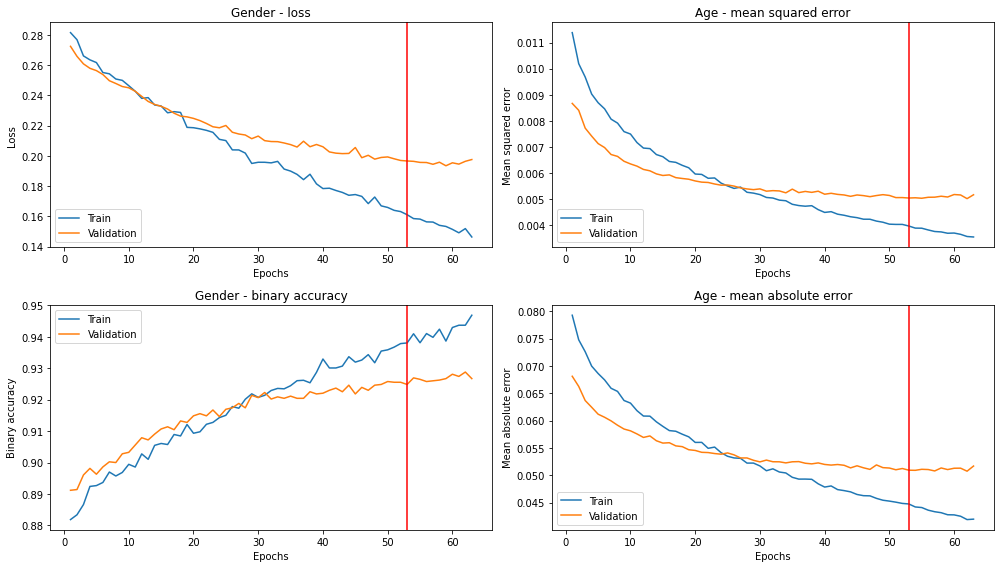

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'mtl'
FOLD = 'fold3'
PHASE = 'FT'
# {'mtl':act_g-act_a-norm-loss-gamma , 'gender': act, 'age': act-norm-loss}
CONFIG = 'sigmoid-relu-norm_01-MAE-gamma_0.03'
# Path where data is stored
pickle_file = os.path.join(
    MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG, TRAIN_FILE)
# Plot data
plot_training(pickle_file, save=True)

### Sección 2.2. Mejores parámetros para clasificación gender

In [ ]:
# GLOBAL VARIABLES
HW = 'GPU'
NET = 'efficientNetB0'
TASK = 'gender'
FOLD = 'fold0'
PHASE = '*'
CONFIG = '*'
# Path where data is stored
dir_path = os.path.join(MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get DataFrame
df_gender = compare_models(
    dir_path,
    TASK,
    hide_cols=['net', 'fold', 'lr'],
    sort_by='test_acc',
    ascending=False,
    to_save=True
)
display(df_gender)

,hw,phase,activ_gender,time,b_epoch,train_acc,val_acc,test_acc
0,GPU,FT,softmax,1:14:50,16,98.06%,93.34%,93.34%
1,GPU,FT,sigmoid,0:56:05,10,96.02%,92.95%,92.95%
2,GPU,TL,sigmoid,0:10:01,3,86.04%,88.28%,88.28%
3,GPU,TL,softmax,0:24:08,18,86.37%,88.21%,88.21%


### Sección 2.3. Mejores parámetros para regresión age

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'age'
FOLD = 'fold0'
PHASE = 'FT'
CONFIG = '*'
# Path where data is stored
dir_path = os.path.join(MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get DataFrame
df_age = compare_models(
    dir_path,
    TASK,
    hide_cols=['hw', 'net', 'fold', 'phase', 'lr'],
    sort_by='test_mae',
    to_save=True
)
display(df_age)

,activ_age,norm,age_loss,time,b_epoch,train_mse,train_mae,val_mse,val_mae,test_mse,test_mae
0,relu,norm_01,MAE,0:14:32,61,0.0037,0.0428,0.0050,0.0502,0.0051,0.0502
1,linear,norm_01,MAE,0:14:27,60,0.0040,0.0452,0.0051,0.0506,0.0051,0.0505
2,linear,no_norm,MAE,0:15:11,63,0.0039,0.0452,0.0052,0.0514,0.0053,0.0513
3,relu,no_norm,MAE,0:14:42,60,0.0037,0.0435,0.0051,0.0516,0.0052,0.0514
4,linear,no_norm,MSE,0:15:06,62,0.0033,0.0450,0.0051,0.0522,0.0051,0.0517
5,relu,no_norm,MSE,0:13:10,51,0.0035,0.0455,0.0051,0.0522,0.0051,0.0520
6,relu,norm_01,MSE,0:06:07,15,0.0063,0.0599,0.0060,0.0559,0.0060,0.0556
7,linear,norm_01,MSE,0:07:09,21,0.0065,0.0625,0.0060,0.0570,0.0060,0.0567
8,tanh,norm_11,MAE,0:13:58,57,0.0148,0.0882,0.0198,0.0999,0.0202,0.1002
9,tanh,norm_11,MSE,0:10:02,36,0.0173,0.1015,0.0208,0.1053,0.0211,0.1049


### Sección 2.4. Multi-task learning


#### Optimización de gamma

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'mtl'
FOLD = 'fold0'
PHASE = 'FT'
CONFIG = 'sigmoid-relu-norm_01-MAE-gamma_0.0?'
# Path where data is stored
dir_path = os.path.join(MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get DataFrame
df_gamma = compare_models(
    dir_path,
    TASK,
    hide_cols=['hw', 'net', 'fold', 'phase', 'lr', 'activ_gender', 'activ_age',
               'norm', 'age_loss'],
    sort_by='gamma',
    to_save=True
)
display(df_gamma)

,gamma,time,b_epoch,train_acc,train_mse,train_mae,val_acc,val_mse,val_mae,test_acc,test_mse,test_mae
0,0.0100,0:13:16,50,91.05%,0.0041,0.0456,90.70%,0.0052,0.0512,90.77%,0.0052,0.0511
1,0.0200,0:13:09,49,92.44%,0.0041,0.0456,91.97%,0.0052,0.0512,92.00%,0.0053,0.0511
2,0.0300,0:15:03,59,94.01%,0.0038,0.0433,92.37%,0.0050,0.0502,92.48%,0.0050,0.0500
3,0.0400,0:14:29,56,94.72%,0.0039,0.0443,92.48%,0.0051,0.0508,92.41%,0.0051,0.0506
4,0.0500,0:12:29,45,94.52%,0.0044,0.0473,93.27%,0.0051,0.0510,93.25%,0.0052,0.0508
5,0.0600,0:11:34,40,94.73%,0.0046,0.0486,92.83%,0.0052,0.0513,92.58%,0.0053,0.0513
6,0.0700,0:12:52,47,95.65%,0.0044,0.0474,92.69%,0.0053,0.0516,92.71%,0.0053,0.0515
7,0.0800,0:13:26,50,96.53%,0.0042,0.0458,93.02%,0.0052,0.0510,92.99%,0.0053,0.0511
8,0.0900,0:11:23,39,95.68%,0.0049,0.0503,93.06%,0.0054,0.0524,92.85%,0.0055,0.0525


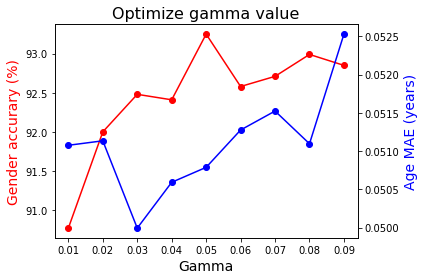

In [ ]:
plot_gamma(df_gamma, dataset='test')

#### Validación Cruzada

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'mtl'
FOLD = '*'
PHASE = 'FT'
CONFIG = 'sigmoid-relu-norm_01-MAE-gamma_0.03'
# Path where data is stored
dir_path = os.path.join(MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get DataFrame
df_cv = compare_models(
    dir_path,
    TASK,
    hide_cols=['hw', 'net', 'phase', 'lr', 'activ_gender', 'activ_age', 'norm',
               'age_loss', 'gamma'],
    sort_by='fold',
    to_save=True
)
display(df_cv)

,fold,time,b_epoch,train_acc,train_mse,train_mae,val_acc,val_mse,val_mae,test_acc,test_mse,test_mae
0,fold0,0:15:03,59,94.01%,0.0038,0.0433,92.37%,0.0050,0.0502,92.48%,0.0050,0.0500
1,fold1,0:14:29,55,93.78%,0.0039,0.0448,92.67%,0.0049,0.0495,92.71%,0.0049,0.0494
2,fold10,0:12:33,46,93.33%,0.0043,0.0467,92.32%,0.0053,0.0514,92.44%,0.0054,0.0517
3,fold2,0:12:45,47,93.14%,0.0042,0.0460,92.78%,0.0051,0.0504,92.76%,0.0051,0.0505
4,fold3,0:14:01,53,93.80%,0.0040,0.0447,92.48%,0.0050,0.0509,92.81%,0.0051,0.0508
5,fold4,0:12:56,47,93.53%,0.0042,0.0459,91.81%,0.0048,0.0503,91.79%,0.0049,0.0504
6,fold5,0:11:10,38,92.90%,0.0046,0.0485,91.53%,0.0046,0.0495,91.46%,0.0046,0.0493
7,fold6,0:13:27,50,93.47%,0.0043,0.0464,92.44%,0.0046,0.0491,92.48%,0.0046,0.0491
8,fold7,0:12:11,43,93.22%,0.0044,0.0471,91.79%,0.0052,0.0514,91.74%,0.0052,0.0513
9,fold8,0:13:53,52,93.58%,0.0039,0.0446,91.79%,0.0051,0.0511,91.76%,0.0052,0.0510


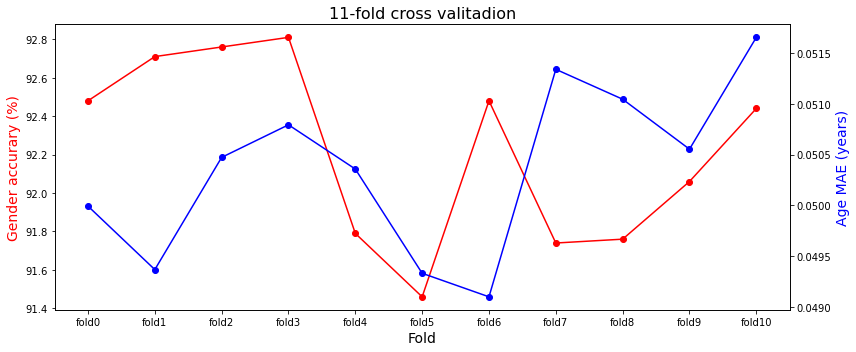

In [ ]:
plot_cv(df_cv, dataset='test')

### Sección 2.5. Resultados sobre conjunto de test

#### Matrix de confusión para clasificación del género

Accuracy over test dataset is 93.16%
Figure save in /content/drive/MyDrive/TFM/figs/RESULTS_gender_cmatrix.png


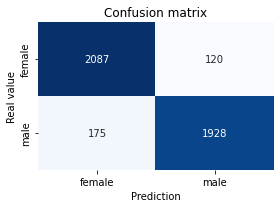

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'gender'
FOLD = 'fold0'
PHASE = 'FT'
CONFIG = 'sigmoid'
# Path where data is stored
dir_path = os.path.join(MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get info
test_model(dir_path, TASK, save=True, msg=True)

#### Gráfico de dispersión para regresión de edad

El error absoluto medio es de 5.77 años.
Figure save in /content/drive/MyDrive/TFM/figs/RESULTS_age_regression.png


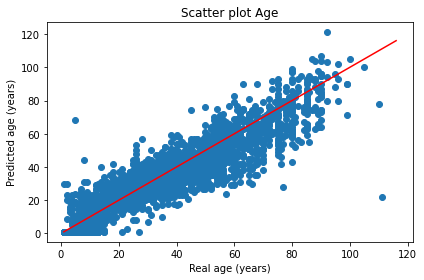

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'age'
FOLD = 'fold0'
PHASE = 'FT'
CONFIG = 'relu-norm_01-MAE'
# Path where data is stored
dir_path = os.path.join(
    MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get info
test_model(dir_path, TASK, save=True, msg=True)

#### Ambas para Multi-tast learning

Accuracy over test dataset is 92.81%
Figure save in /content/drive/MyDrive/TFM/figs/RESULTS_mtl_cmatrix.png
El error absoluto medio es de 5.84 años.
Figure save in /content/drive/MyDrive/TFM/figs/RESULTS_mtl_regression.png


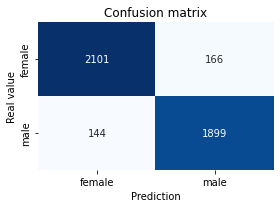

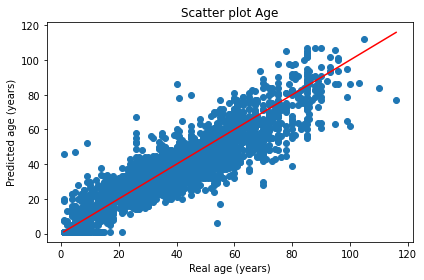

In [ ]:
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'mtl'
FOLD = 'fold3'
PHASE = 'FT'
CONFIG = 'sigmoid-relu-norm_01-MAE-gamma_0.03'
# Path where data is stored
dir_path = os.path.join(
    MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG)
# Get info
test_model(dir_path, TASK, save=True, msg=True)

## Sección 3. Ejemplo de predicción sobre modelo MTL óptimo

In [ ]:
activ_gender, gamma = 'sigmoid', 'gamma_0.03'
activ_age, norm, age_loss = 'relu', 'norm_01', 'MAE'
f_norm, f_denorm = dict_norm[norm], dict_denorm[norm]
# GLOBAL VARIABLES
HW = 'TPU'
NET = 'efficientNetB0'
TASK = 'mtl'
FOLD = 'fold3'
PHASE = 'FT'
CONFIG = f'{activ_gender}-{activ_age}-{norm}-{age_loss}-{gamma}'
# Load model
model_file = os.path.join(
    MODELS_PATH, HW, NET, TASK, FOLD, PHASE, CONFIG, MODEL_FILE)
model = tf.keras.models.load_model(model_file)
# Load fold3 test set
GCS_TEST_PATTERN = f'{GCS_BUCKET}/{FOLD}/test*.tfrecord'
test_files, test_steps = tf.io.gfile.glob(f'gs://{GCS_TEST_PATTERN}'), 17
test_ds = get_dataset(test_files[0:1], TASK, activ_gender, f_norm).take(1)
# Predict data
pred_gender, pred_age = model.predict(test_ds, verbose=0) # Predictions
pred_gender = np.round(pred_gender).flatten().astype(np.int64)
pred_age = f_denorm(np.array(pred_age).flatten()).astype(np.int64)
# Real data
images = test_ds.map(lambda img, lab: img) # Gets only images from Dataset
images = next(images.as_numpy_iterator())
labels = test_ds.map(lambda img, lab: lab) # Gets only labels from Dataset
labels = next(labels.as_numpy_iterator())
real_gender, real_age = labels['gender_output'], labels['age_output']
real_gender = np.array(real_gender)
real_age = f_denorm(np.array(real_age)).astype(np.int64)

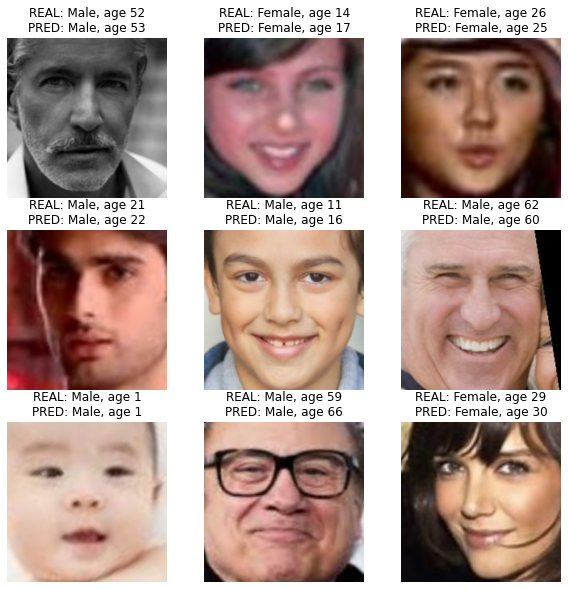

In [ ]:
# Plot figure
index = np.random.default_rng(seed=123).integers(low=0, high=256, size=9)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(index):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[idx]/255) # pixels between 0 and 1
  plt.title(
      f'REAL: {alias[real_gender[idx]].capitalize()}, age {real_age[idx]}'\
      f'\nPRED: {alias[pred_gender[idx]].capitalize()}, age {pred_age[idx]}'
  )
  plt.axis('off')
plt.savefig(os.path.join(FIGS_PATH, 'mtl_predictions.png'), dpi=200)